In [1]:
import pandas
data = pandas.read_csv("CIR相位集中上传.csv")
resu = []
rolling = None
resu2 = []
for _,i in data.iterrows():
    if rolling != i['rolling']:
        if len(resu2)>0:
            resu2 = pandas.DataFrame(resu2)
            resu2['IQ'] = resu2['IQ'].apply(lambda x: complex(x))
            resu.append(resu2)
        rolling = i['rolling']
        resu2 = []
    resu2.append(i)
del resu2 
del rolling 
del i 
del data

In [7]:
import matplotlib.pyplot as plt
import time,tqdm,warnings,datetime
import numpy as np
class CIRDisplay:
    def __init__(self):
        self.reset()
        # 以下五个是配置 从配置文件里读即可
        self.movMeanBufferSize = 100 # 滤波窗口 典型值0~1000
        self.readoutBufferSize = 100 # 显示窗口 典型值0~1000
        self.AnchorIdxCount = 2      # 基站数量 
        self.referenceID = 51701     # 待测标签编号
        self.tagID = 54883           # 参考标签编号
    def reset(self):
        self.readouts = []
        self.movMeanBuffer = []
        self.readoutTime = []
    def step(self,frame):
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        result = np.zeros((2,self.AnchorIdxCount),dtype=np.complex64)*np.nan
        for i in range(2):
            for _ancid in range(self.AnchorIdxCount):
                _tagid = [self.referenceID,self.tagID][i]
                value = np.array(frame[(frame['TagID']==_tagid) & (frame['AnchorIdx']==_ancid)]['IQ'])
                if len(value)==1:result[i,_ancid] = np.array(value[0])
        readout = result / np.abs(result)
        readout = readout[:,1:] / readout[:,None,0] # 同一标签收到的2个基站的相位差
        readout = readout[1,:] / readout[0,:] # 两个标签分别收到的2个基站的相位差之差(双差)
        readout = readout[None,...]
        if any(np.isfinite(readout)):
            self.movMeanBuffer.append(readout)
            self.movMeanBuffer=self.movMeanBuffer[-self.movMeanBufferSize:]
            self.readouts.append(np.mean(np.concatenate(self.movMeanBuffer,0),0)[None,...])
            self.readouts=self.readouts[-self.readoutBufferSize:]
            self.readoutTime.append(datetime.datetime.now())
            self.readoutTime=self.readoutTime[-self.readoutBufferSize:]
    def show(self):
        return self.readoutTime,np.angle(np.concatenate(self.readouts,0))*180/np.pi # 呈现这个数据 单位为度 y轴标签:相位双差读数/度 x轴标签:
cirDisp = CIRDisplay()
t0=time.time()
for frame in resu:#tqdm.tqdm(resu):
    cirDisp.step(frame)

Text(0.5, 1.0, '待测标签:D663\n参考标签:C9F5')

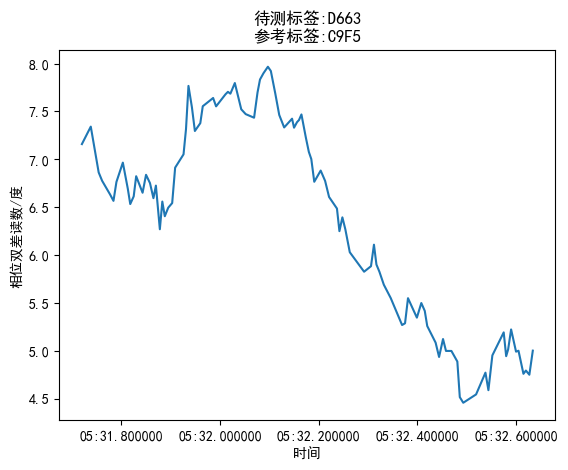

In [8]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.plot(*cirDisp.show())
plt.xlabel('时间')
plt.ylabel('相位双差读数/度')
plt.title("""待测标签:%04X
参考标签:%04X"""%(cirDisp.tagID,cirDisp.referenceID))